<a href="https://colab.research.google.com/github/balaajhi/One-step-at-a-time/blob/main/LSTM_AC_TO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install nsepy

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
from nsepy import get_history
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None

In [ ]:
%pip install yfinance

     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 14.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import datetime as dt
start = date(2017, 1, 1)
end = dt.datetime.today()
data = pd.DataFrame()
#interval = "1m"
ticker = 'AC.TO'
df= yf.download(ticker,start,end)
data['Close']= df[['Adj Close']]
data

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2017-01-03,13.830000
2017-01-04,13.720000
2017-01-05,13.740000
2017-01-06,13.560000
2017-01-09,13.500000
...,...
2022-01-31,22.860001
2022-02-01,23.670000
2022-02-02,23.420000


In [ ]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
z = scaler.transform(data)

In [ ]:
# extract the input sequences and target values
window_size = 60

x, y = [], []

for i in range(window_size, len(z)):
    x.append(z[i - window_size: i])
    y.append(z[i])

x, y = np.array(x), np.array(y)

In [ ]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=x.shape[1:]))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
10/10 [==============================] - 4s 96ms/step - loss: 0.0717
Epoch 2/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0134
Epoch 3/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0075
Epoch 4/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0047
Epoch 5/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0035
Epoch 6/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0031
Epoch 7/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0028
Epoch 8/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0027
Epoch 9/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0026
Epoch 10/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0025
Epoch 11/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0024
Epoch 12/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0023
Epoch 13/100
10/10 [=====

In [ ]:
# generate the multi-step forecasts
def multi_step_forecasts(n_past, n_future):

    x_past = x[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame
    df_past = data.rename(columns={'Close': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

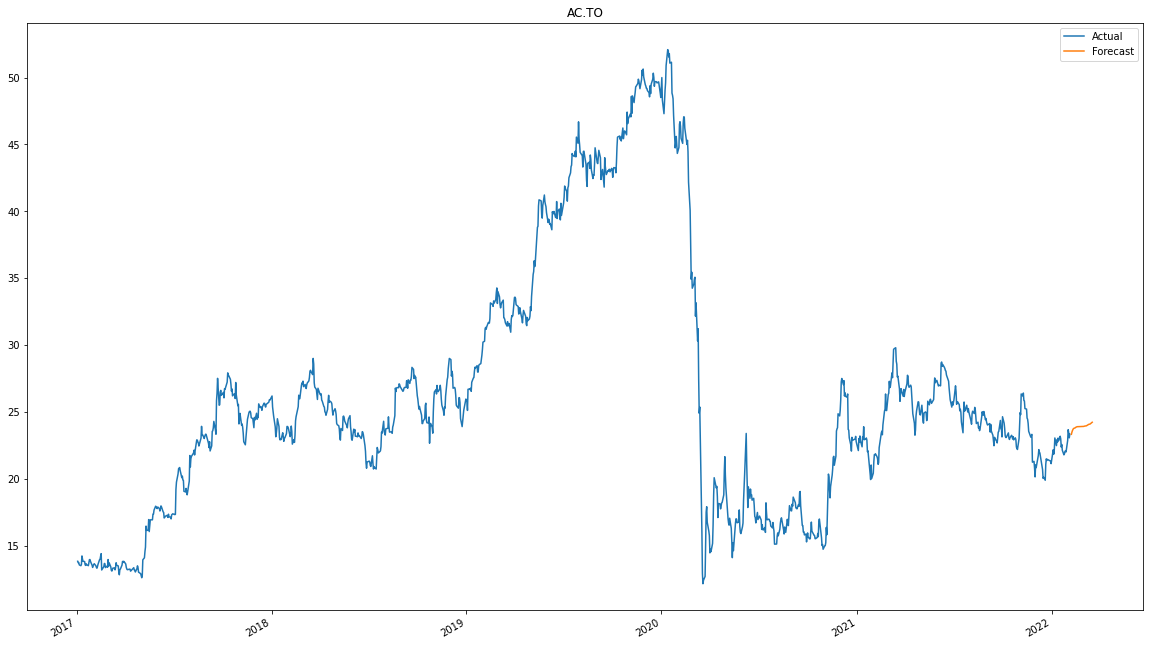

In [ ]:
# forecast the next 30 days
df1 = multi_step_forecasts(n_past=0, n_future=30)
df1.plot(title=ticker,figsize=(20,12))


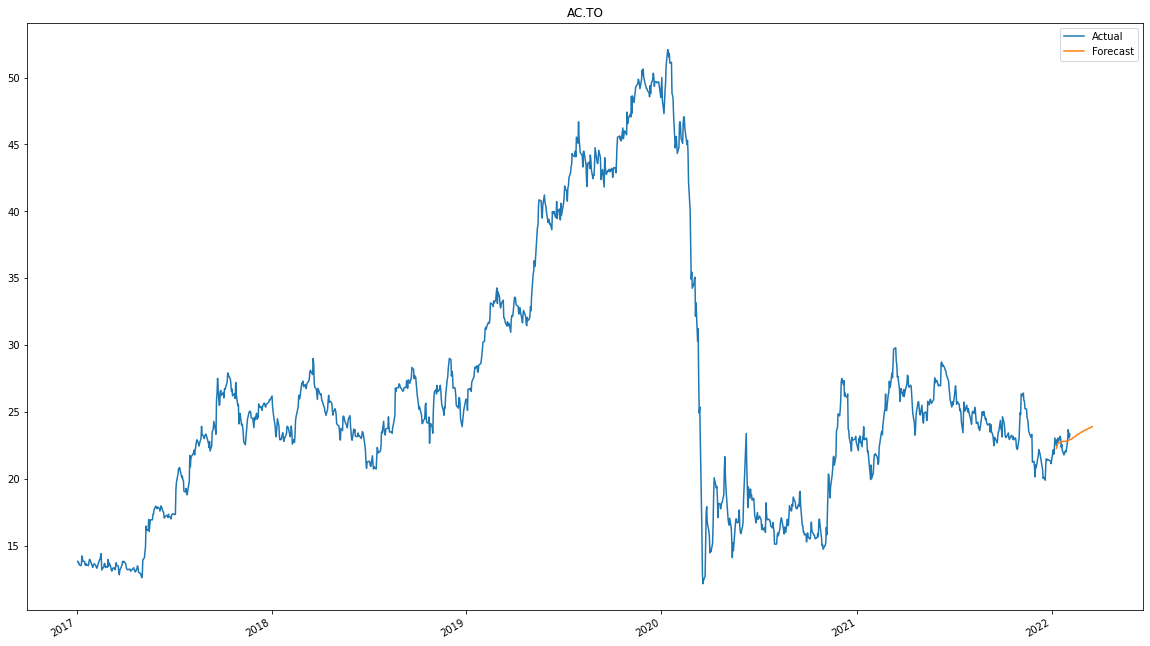

In [ ]:
# forecast the last 20 days and the next 30 days
df2 = multi_step_forecasts(n_past=20, n_future=30)
df2.plot(title=ticker,figsize=(20,12))

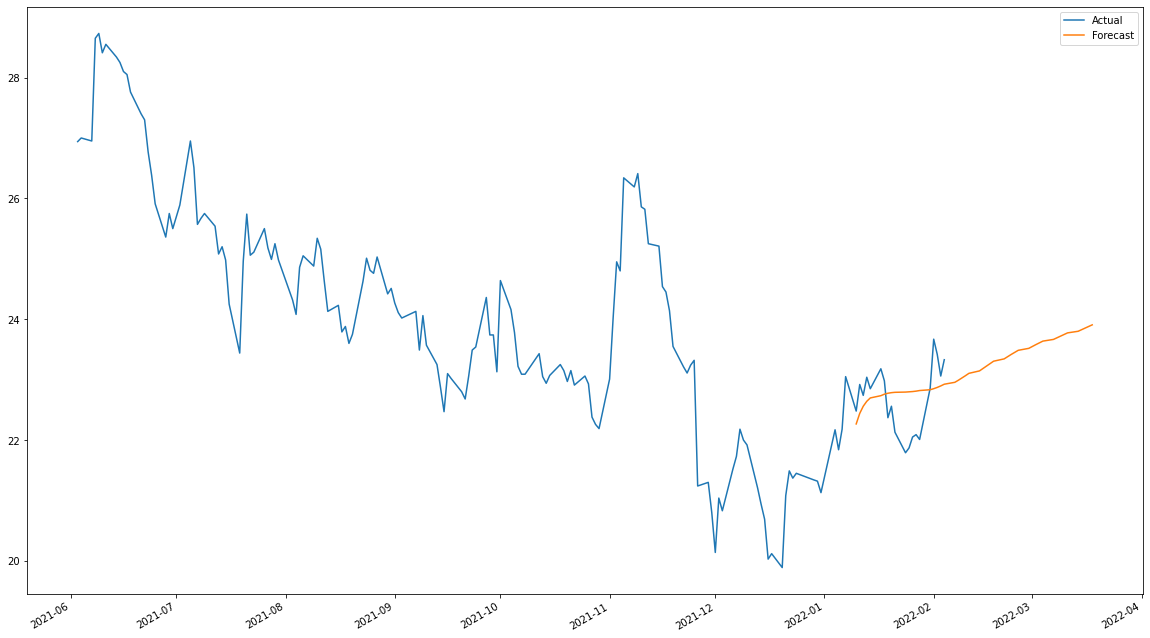

In [ ]:
df2.iloc[-200:].plot(figsize=(20,12))